In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
class1_ls = pd.read_csv("Group15/LS_Group15/Class1.txt", sep=' ', header=None)
class2_ls = pd.read_csv("Group15/LS_Group15/Class2.txt", sep=' ', header=None)
class3_ls = pd.read_csv("Group15/LS_Group15/Class3.txt", sep=' ', header=None)

In [8]:
class1_ls.head()

,0,1
0,-2.2365,2.3224
1,2.4445,4.5807
2,1.8720,1.1315
3,5.1338,1.0316
4,2.1731,2.2868


In [9]:
class1_ls = class1_ls.assign(Class=1)
class2_ls = class2_ls.assign(Class=2)
class3_ls = class3_ls.assign(Class=3)

In [10]:
class1_ls.head()

,0,1,Class
0,-2.2365,2.3224,1
1,2.4445,4.5807,1
2,1.8720,1.1315,1
3,5.1338,1.0316,1
4,2.1731,2.2868,1


In [14]:
df = pd.concat([class1_ls, class2_ls, class3_ls], ignore_index=True)
df

,0,1,Class
0,-2.2365,2.3224,1
1,2.4445,4.5807,1
2,1.8720,1.1315,1
3,5.1338,1.0316,1
4,2.1731,2.2868,1
...,...,...,...
1495,17.1120,-6.9613,3
1496,16.8170,-2.7400,3
1497,14.7910,-3.5821,3
1498,17.1720,-9.3333,3


In [16]:
from sklearn.model_selection import train_test_split

X, y = df.drop('Class', axis=1), df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [17]:
X_train.head()

,0,1
195,3.5791,1.6013
1389,16.2300,-4.9494
772,7.4558,-12.5360
737,6.3671,-11.2000
33,1.2503,1.3749


Classifier 1: Covariance matrix for all the classes is the same and is $\sigma^2 I$

In [26]:
df_train = pd.concat([X_train, y_train], axis=1)
df_train.head()

,0,1,Class
195,3.5791,1.6013,1
1389,16.2300,-4.9494,3
772,7.4558,-12.5360,2
737,6.3671,-11.2000,2
33,1.2503,1.3749,1


In [64]:
df_train = df_train.reset_index(drop=True)
df_train.head()

,0,1,Class
0,3.5791,1.6013,1
1,16.2300,-4.9494,3
2,7.4558,-12.5360,2
3,6.3671,-11.2000,2
4,1.2503,1.3749,1


In [65]:
df_test = pd.concat([X_test, y_test], axis=1)
df_test.head()

,0,1,Class
274,1.4691,4.36690,1
517,7.8709,-15.88700,2
173,3.1378,0.97421,1
1347,15.4060,-8.81120,3
1158,15.4700,-9.40680,3


In [66]:
df_test = df_test.reset_index(drop=True)
df_test.head()

,0,1,Class
0,1.4691,4.36690,1
1,7.8709,-15.88700,2
2,3.1378,0.97421,1
3,15.4060,-8.81120,3
4,15.4700,-9.40680,3


In [27]:
class_variances = df_train.groupby('Class').var()
class_variances

,0,1
Class,,
1,8.362977,2.430909
2,2.795871,4.645057
3,2.097561,9.466011


In [28]:
avg_var = class_variances.mean(axis=0)
avg_var

0    4.418803
1    5.513992
dtype: float64

In [45]:
import numpy as np

cov_mat = np.zeros((len(avg_var), len(avg_var)))

for i in range(len(avg_var)):
    cov_mat[i][i] = avg_var[i]

cov_mat

array([[4.41880323, 0.        ],
       [0.        , 5.5139925 ]])

In [30]:
class_means = df_train.groupby('Class').mean()
class_means

,0,1
Class,,
1,1.249336,2.127678
2,5.919546,-12.001571
3,15.938185,-3.883870


In [58]:
def discriminant_function(x, mu, sigma, prior):
    return -1/2 * (np.transpose(x - mu) @ np.linalg.inv(sigma) @ (x - mu)) + np.log(prior)

In [80]:
y_pred = []

for idx in range(len(X_test)):
    x = X_test.iloc[idx]
    gs = []

    for i in range(3):
        gs.append(discriminant_function(x, class_means.iloc[i], cov_mat, 1/3))
    
    y_pred.append(np.argmax(gs) + 1)


In [92]:
def confusion_mat(y_pred, y_test):
    M = np.unique(y_test).size

    conf_mat = np.zeros((M, M))

    for i in range(len(y_test)):
        conf_mat[y_pred[i]-1][y_test[i]-1] += 1
    
    return conf_mat

In [93]:
confusion_mat(y_pred, np.array(y_test))

array([[161.,   0.,   0.],
       [  0., 130.,   1.],
       [  0.,   0., 158.]])

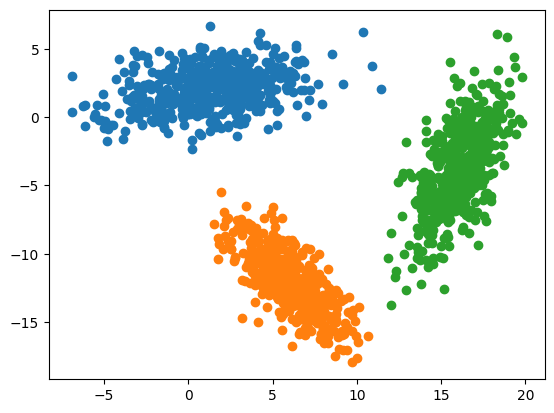

In [95]:
plt.scatter(class1_ls[0], class1_ls[1])
plt.scatter(class2_ls[0], class2_ls[1])
plt.scatter(class3_ls[0], class3_ls[1])